In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x /content/drive/MyDrive/GaitSet\ Sillhoutes/open-images-bus-trucks.rar -o+ /content/data/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Cannot open /content/drive/MyDrive/GaitSet Sillhoutes/open-images-bus-trucks.rar
No such file or directory
No files to extract


In [ ]:
from torch import cuda,optim
from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
from torchvision.ops import nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd,numpy as np
import torchsummary
from torch import nn
from pathlib import Path
from pandas import DataFrame as df
from glob import glob
device = 'cuda' if cuda.is_available() else 'cpu'
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

DS_FOLDER = '/content/data/open-images-bus-trucks'
IMAGE_ROOT = DS_FOLDER + '/images'
df = pd.read_csv(DS_FOLDER+'/df.csv')
df.columns

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y',
       'XClick2Y', 'XClick3Y', 'XClick4Y'],
      dtype='object')

In [ ]:
label2targets = {l: t+1 for t,l in enumerate(df['LabelName'].unique())}
label2targets['background'] = 0
target2labels = {i:t for t,i in label2targets.items()}
background_class = label2targets['background']
num_classes = len(label2targets)

In [ ]:
sum({'hello':1,'one':2}.values())

3

In [ ]:
def process_img(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [ ]:
class OpenDataset(Dataset):
    def __init__(self,df,images_path=IMAGE_ROOT):
        self.w,self.h = 224,224
        self.images_path = images_path
        self.files = glob(images_path + '/*')
        self.df = df
        self.image_info = df['ImageID'].unique()
    def __getitem__(self, index):
        image_id = self.image_info[index]
        img_path = list(filter(lambda path : path.find(image_id)!=-1,self.files))[0]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w,self.h),resample = Image.BILINEAR))/255
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName']
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h

        boxes = data.astype(np.uint32).tolist()
        target = {}
        target['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label2targets[i] for i in labels]).long()
        img = process_img(img)
        return img,target

    def collate_fn(self,batch):
        return tuple(zip(*batch))
    def __len__(self):
        return len(self.image_info)

In [ ]:
from sklearn.model_selection import train_test_split

train_ids,test_ids = train_test_split(df.ImageID.unique()[:100],test_size=.1)
train_df,test_df = df[df['ImageID'].isin(train_ids)],df[df['ImageID'].isin(test_ids)]
train_ds ,test_ds = OpenDataset(train_df),OpenDataset(test_df)

In [ ]:
test_ids

array(['0025e76bf1c441bf', '005ad428291130ff', '001bdbbf7a3ac993',
       '00036603fa39fa85', '0068633242ebb5da', '001ae662d690368e',
       '001ca84e28488f7a', '0007eeeabf3c5e5c', '0054a7ba5f5b9ee7',
       '0046022a3de49481'], dtype=object)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=4,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4,collate_fn=test_ds.collate_fn,drop_last=True)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn,FasterRCNN_ResNet50_FPN_Weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def faster_model():
    model = fasterrcnn_resnet50_fpn(weights= FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(faster_model(),input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [ ]:
def train_batch(inputs,model,optimizer):
    input,targets = inputs
    input = [image.to(device) for image in input ]
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input,targets)
    loss = sum(losses.values())
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy(),losses

@torch.no_grad
def eval_batch(inputs,model):
    model.train()
    input,targets = inputs
    input = [image.to(device) for image in input ]
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    losses = model(input,targets)
    loss = sum(losses.values())
    return loss.detach().cpu().float(),losses


images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 12, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(0, 3, (4, 12))
images = list(image for image in images)
targets = []
model = faster_model()
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)

In [ ]:
model = faster_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,momentum=0.9,weight_decay=0.0005)
n_epochs = 4
train_epoch_accs ,test_epoch_accs,train_epoch_loss,test_epoch_loss = [],[],[],[]
for ex in range(n_epochs):
    N = len(train_loader)
    train_losses, train_accs = [],[]
    for bx, data in enumerate(train_loader):
        loss, losses = train_batch(data,model, optimizer)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        train_losses.append(loss)
        logger.info(f'train loss = {loss},train regr_loss is {regr_loss}  on bx {bx}')

    train_epoch_accs.append(np.mean(train_accs))
    train_epoch_loss.append(np.mean(train_losses))
    N = len(test_loader)
    test_losses = []
    for bx, data in enumerate(test_loader):
        loss, losses = eval_batch(data,model)
        loc_loss, regr_loss, loss_objectness, \
            loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', \
                'loss_box_reg', 'loss_objectness', \
                'loss_rpn_box_reg']]
        print(f'loss is {loss}')
        test_losses.append(loss)
        logger.info(f'val loss = {loss},train regr_loss is {regr_loss}')


    test_epoch_loss.append(np.mean(test_losses))

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


loss is 0.45242369174957275
loss is 0.4285719394683838


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


loss is 0.3986680209636688
loss is 0.46751663088798523


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


loss is 0.4342304468154907
loss is 0.5013721585273743


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


loss is 0.4404493570327759
loss is 0.4719388782978058


In [ ]:
test_epoch_loss

[np.float32(0.44049782),
 np.float32(0.43309233),
 np.float32(0.4678013),
 np.float32(0.4561941)]

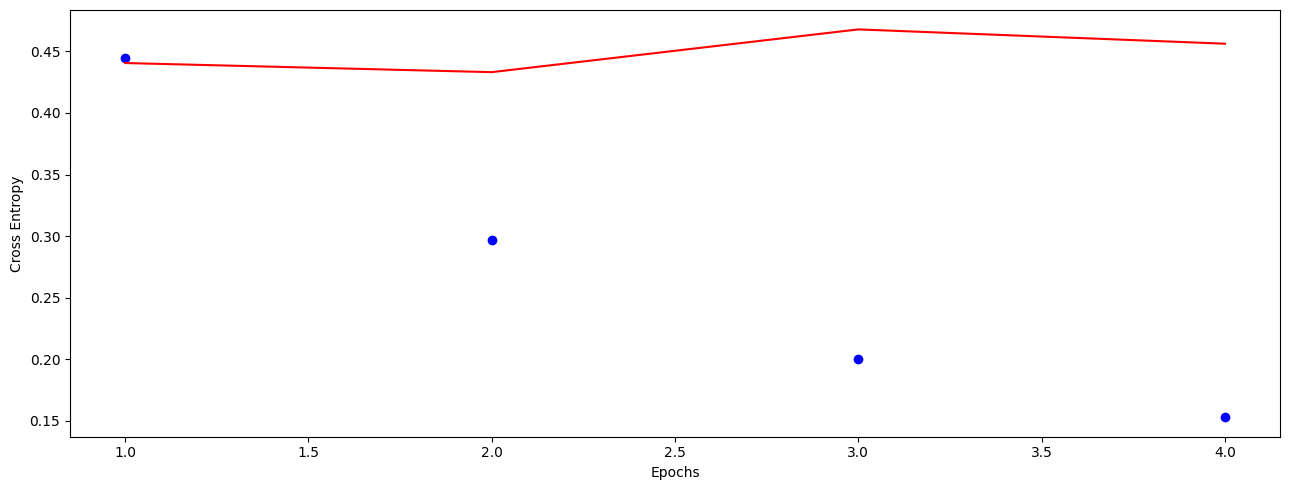

In [ ]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(1,1,figsize=(13,5))


ax.plot(epochs, train_epoch_loss, 'bo')
ax.plot(epochs, test_epoch_loss, 'r')


ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy')

fig.tight_layout()
plt.show()

In [ ]:
from torchvision.ops import nms
def decode_output(output):
  bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
  labels = np.array([target2labels[i] for i in  output['labels'].cpu().detach().numpy()])
  confs = output['scores'].cpu().detach().numpy()
  ixs = nms(torch.tensor(bbs.astype(np.float32)),torch.tensor(confs), 0.05)
  bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
  if len(ixs) == 1:
    bbs,confs,labels = [np.array([tensor]) for tensor   in [bbs, confs, labels]]
  return bbs.tolist(), confs.tolist(), labels.tolist()

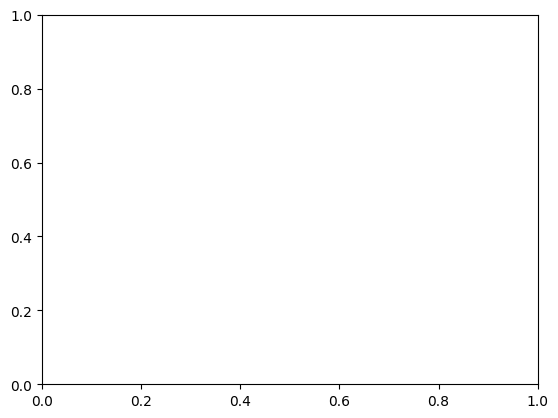

length of images and targets respectively
	images:3
	targets2


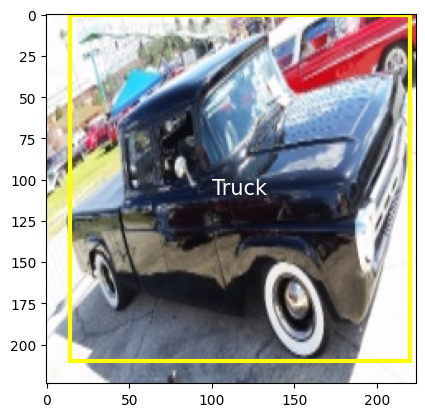

In [ ]:
def show(ax,img,titles,boxes,size):
    for ix,box in enumerate(boxes):
        bottom_left = box[0],box[1]
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]
        rectangle = patches.Rectangle(
            bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
            facecolor='none'
            )
        ax.text(bottom_left[0] + box_width / 2, bottom_left[1] + box_height/2 , titles[ix],
            horizontalalignment='center', verticalalignment='center',
            fontsize=15, color='white')
        ax.add_patch(rectangle)
    ax.imshow(img)
    plt.show()



fig, ax = plt.subplots()
model.eval()
image,target = test_ds[0]
print(f'length of images and targets respectively'\
            f'\n\timages:{len(image)}\n\ttargets{len(target)}')

#WE GIVE A BATCH TO THE MODEL
#OUTPUTS IS A LIST, CONTAINING A DICTIONARY
#THE DICTIONARY CONTAINS BOXES,SCORES AND LABELS

outputs = model(image.unsqueeze(0))
for ix, output in enumerate(outputs):
  bbs, confs, labels = decode_output(output)
  #[print(f'{l}@{c:.2f}') for l,c in zip(labels,confs)]
  show(ax,image.cpu().permute(1,2,0), labels, bbs, (15,15))

In [ ]:
plt.show()

# YOLO samples

In [ ]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [ ]:
%ls

3rdparty/               data/                  obj/
backup/                 docker-compose.yml     open-images-bus-trucks/
build/                  Dockerfile.cpu         package.xml
build.ps1               Dockerfile.gpu         README.md
cfg/                    image_yolov3.sh        results/
cmake/                  image_yolov4.sh        scripts/
CMakeLists.txt          include/               src/
darknet                 json_mjpeg_streams.sh  vcpkg.json
DarknetConfig.cmake.in  LICENSE                video_yolov3.sh
darknet_images.py       Makefile               video_yolov4.sh
darknet.py              net_cam_v3.sh          yolov4.weights
darknet_video.py        net_cam_v4.sh


In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [12]:
cd /content/drive/MyDrive/darknet/

/content/drive/MyDrive/darknet


In [3]:
!chmod  777 darknet

In [5]:
! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights ../images/images.jpg

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

In [6]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [7]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [8]:
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

cp: cannot stat 'open-images-bus-trucks/yolo_labels/all/train.txt': No such file or directory
cp: cannot stat 'open-images-bus-trucks/yolo_labels/all/val.txt': No such file or directory
